In [1]:
# ==============================================================================
# 1. 라이브러리 임포트
# ==============================================================================
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm # 로컬에서는 tqdm.notebook 대신 일반 tqdm 사용
import joblib

# skimage
from skimage.exposure import rescale_intensity, equalize_hist
from skimage.filters import gaussian
from skimage.restoration import denoise_bilateral
from skimage.util import img_as_ubyte
from skimage.feature import local_binary_pattern, hog
from skimage.transform import resize
from scipy import ndimage

# sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier # 사용하지는 않지만 임포트 유지
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import LabelEncoder,normalize
from sklearn.metrics import pairwise_distances

from imblearn.over_sampling import RandomOverSampler


# joblib (병렬 처리를 위해)
from joblib import Parallel, delayed

# faiss (KNN 가속화를 위해)
import faiss

# Ensemble
from Ensemble import EnsembleFaissKNN
print("✔ 모든 라이브러리 임포트 완료!")

✔ 모든 라이브러리 임포트 완료!


In [2]:
# ==============================================================================
# 2. 데이터 로딩 및 준비
# ==============================================================================

DATASET_BASE_PATH = "C:/Users/bvb09/.cache/kagglehub/datasets/cry2003/google-recaptcha-v2-images/versions/1/"

# 이미지 로드 함수
def load_images_from_folder(base_path, img_size=(120, 120)):
    images = []
    labels = []
    # 데이터셋 구조: Google_Recaptcha_V2_Images_Dataset/images/<label>/<image>.jpg
    image_folder_path = os.path.join(base_path, 'images')
    
    if not os.path.exists(image_folder_path):
        raise FileNotFoundError(f"이미지 폴더를 찾을 수 없습니다: {image_folder_path}\n"
                                f"DATASET_BASE_PATH를 올바르게 설정했는지 확인해주세요.")

    for label_name in tqdm(os.listdir(image_folder_path), desc="Loading folders"):
        label_path = os.path.join(image_folder_path, label_name)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        images.append(img)
                        labels.append(label_name)
                    else:
                        print(f"경고: {img_path} 이미지를 로드할 수 없습니다.")
                except Exception as e:
                    print(f"경고: {img_path} 로딩 중 오류 발생 - {e}")
    return pd.DataFrame({'image_data': images, 'label': labels})

print("▶ 이미지 데이터 로드 중...")
try:
    images_df = load_images_from_folder(DATASET_BASE_PATH)
    print(f"✔ 총 {len(images_df)}개의 이미지 로드 완료.")

except FileNotFoundError as e:
    print(f"오류: {e}")
    print("데이터셋 경로를 올바르게 설정했는지 확인해주세요.")
    # 프로그램 종료 또는 추가 처리
    exit() # 스크립트 실행을 중단하려면 이 줄의 주석을 해제하세요.


# 라벨 인코딩
le = LabelEncoder()
images_df['label_encoded'] = le.fit_transform(images_df['label'])
print(f"✔ 라벨 인코딩 완료. 클래스: {le.classes_}")

# 데이터셋 불균형 해소
X = np.arange(len(images_df)).reshape(-1, 1)
y = images_df['label_encoded'].values

ros = RandomOverSampler(random_state=42)
X_resampled_idx, y_resampled = ros.fit_resample(X, y)

# 리샘플링 결과 재구성
images_df_resampled = images_df.iloc[X_resampled_idx.flatten()].reset_index(drop=True)
images_df_resampled['label_encoded'] = y_resampled
print(f"✔ Oversampling 완료. 총 샘플 수: {len(images_df_resampled)}")

# 층화 K-Fold 분할 준비
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("✔ Stratified K-Fold 설정 완료 (5-Fold).")


▶ 이미지 데이터 로드 중...


Loading folders: 100%|██████████| 12/12 [00:31<00:00,  2.61s/it]

✔ 총 32246개의 이미지 로드 완료.
✔ 라벨 인코딩 완료. 클래스: ['Bicycle' 'Bridge' 'Bus' 'Car' 'Chimney' 'Crosswalk' 'Hydrant'
 'Motorcycle' 'Other' 'Palm' 'Stair' 'Traffic Light']
✔ Oversampling 완료. 총 샘플 수: 85992
✔ Stratified K-Fold 설정 완료 (5-Fold).


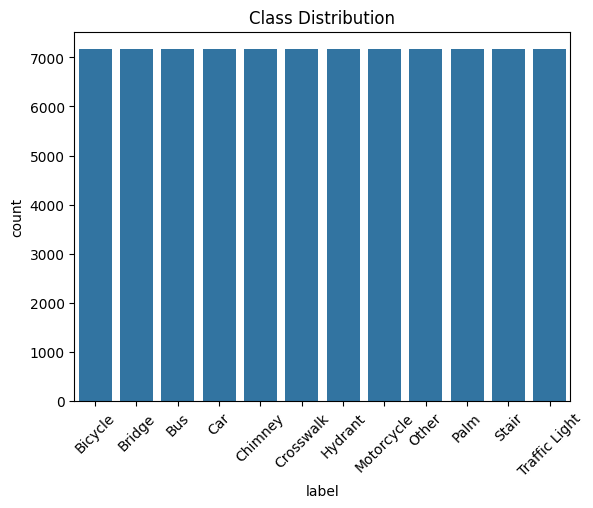

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=images_df_resampled)
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()

In [5]:
# ==============================================================================
# 3. 이미지 전처리 함수 (Colab 버전과 동일)
# ==============================================================================

# 대비 스트레칭
def contrast_stretch(img, p_low=1, p_high=99):
    low, high = np.percentile(img, (p_low, p_high))
    return rescale_intensity(img, in_range=(low, high))

# 그레이스케일 변환
def to_grayscale(img):
    if len(img.shape) == 3 and img.shape[2] == 3:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

# 히스토그램 평활화
def histogram_equalization(image_gray):
    return equalize_hist(image_gray)

# 노이즈 필터링
def remove_noise(image):
    image = gaussian(image, sigma=1)
    denoised_image = denoise_bilateral(image, sigma_color=0.05, sigma_spatial=15, channel_axis=None)
    return img_as_ubyte(denoised_image)

# 엣지 검출 (Canny)
def edge_detection(image_gray, low_threshold=30, high_threshold=200, aperture_size=3):
    if image_gray.dtype != np.uint8:
        image_gray = cv2.convertScaleAbs(image_gray)
    return cv2.Canny(image_gray, low_threshold, high_threshold, apertureSize=aperture_size)

# 선명화
def sharpen_image(image_gray, low_threshold=50, high_threshold=150, amount=1.0):
    edges = cv2.Canny(image_gray, low_threshold, high_threshold)
    mask = (edges / 255.0).astype(np.float32)
    sharpened = image_gray.astype(np.float32) + amount * (mask * 255.0)
    return np.clip(sharpened, 0, 255).astype(np.uint8)

# 전처리 함수
def preprocess_image(img, sigma=1.0):
    img = to_grayscale(img)
    img = contrast_stretch(img)
    img = edge_detection(img)
    return img
print("✔ 이미지 전처리 함수 정의 완료.")

✔ 이미지 전처리 함수 정의 완료.


In [6]:
from sklearn.cluster import MiniBatchKMeans
import cv2
import numpy as np
from tqdm import tqdm

def build_sift_vocabulary(images, n_clusters=200):
    sift = cv2.SIFT_create()
    all_descriptors = []

    for img in tqdm(images, desc="Extracting SIFT descriptors for vocab"):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img
        _, descriptors = sift.detectAndCompute(gray, None)
        if descriptors is not None:
            all_descriptors.append(descriptors)

    all_descriptors = np.vstack(all_descriptors)  # (N, 128)
    print(f"✔ 총 {all_descriptors.shape[0]}개의 SIFT descriptors 추출됨.")

    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=2048)
    kmeans.fit(all_descriptors)
    return kmeans


In [7]:
# ==============================================================================
# 4. 특징 추출 함수 (Colab 버전과 동일)
# ==============================================================================

# LBP (Local Binary Pattern)
def extract_lbp_features(image_gray, num_points=24, radius=3):
    lbp = local_binary_pattern(image_gray, num_points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

# HOG (Histogram of Oriented Gradients)
def extract_hog_descriptors(image_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    if image_gray.dtype == np.uint8:
        image_gray = image_gray.astype(float) / 255.0
    features, _ = hog(image_gray, orientations=orientations,
                      pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block,
                      transform_sqrt=True,
                      block_norm="L2-Hys",
                      visualize=True)
    return features

# SIFT (Scale-Invariant Feature Transform)
def extract_sift_descriptors(image_gray):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image_gray, None)
    if descriptors is None:
        return np.zeros(128)
    return np.mean(descriptors, axis=0) if descriptors.shape[0] > 0 else np.zeros(128)

# Laws' Texture Energy
def extract_laws_energy_features(image_gray, window_size=15):
    L5 = np.array([1, 4, 6, 4, 1], dtype=np.float32)
    E5 = np.array([-1, -2, 0, 2, 1], dtype=np.float32)
    S5 = np.array([-1, 0, 2, 0, -1], dtype=np.float32)
    W5 = np.array([-1, 2, 0, -2, 1], dtype=np.float32)
    R5 = np.array([1, -4, 6, -4, 1], dtype=np.float32)
    kernels = [L5, E5, S5, W5, R5]

    energy_features = []
    if image_gray.dtype == np.uint8:
        image_gray = image_gray.astype(np.float32)

    for k1 in kernels:
        for k2 in kernels:
            kernel = np.outer(k1, k2)
            filtered = ndimage.convolve(image_gray, kernel, mode='reflect')
            energy = np.abs(filtered)
            summed = cv2.boxFilter(energy, ddepth=-1, ksize=(window_size, window_size), normalize=False)
            energy_features.append(summed.mean())

    return np.array(energy_features, dtype=np.float32)

# 모든 특징을 결합하는 함수
def extract_features(image):
    if len(image.shape) == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image

    lbp_feat = extract_lbp_features(image_gray)
    #hog_feat = extract_hog_descriptors(image_gray)
    sift_feat = extract_sift_descriptors(image_gray)
    #laws_feat = extract_laws_energy_features(image_gray)

    lbp_feat = lbp_feat / (np.sum(lbp_feat) + 1e-7)
    #hog_feat = hog_feat / (np.linalg.norm(hog_feat) + 1e-7)
    sift_feat = sift_feat / (np.linalg.norm(sift_feat) + 1e-7)
    #laws_feat = laws_feat / (np.linalg.norm(laws_feat) + 1e-7)

    combined_features = np.concatenate([lbp_feat, sift_feat])
    normalized_features = combined_features / (np.linalg.norm(combined_features) + 1e-7)
    return normalized_features
print("✔ 특징 추출 함수 정의 완료.")

✔ 특징 추출 함수 정의 완료.


In [8]:
# ==============================================================================
# 5. 분류 모델 및 학습/평가 함수 (Faiss 적용, Colab 버전과 동일)
# ==============================================================================

# Cosine Similarity 기반 Faiss KNN 학습
def train_faiss_knn_cosine(X_train, y_train, n_neighbors=5):
    X_train = normalize(X_train, axis=1)  # 중요: 코사인 유사도는 정규화 필요
    X_train = X_train.astype(np.float32)
    D = X_train.shape[1]

    index = faiss.IndexFlatIP(D)  # Inner Product 사용 (정규화 시 코사인과 같음)
    index.add(X_train)

    return index, y_train, n_neighbors

# Cosine Similarity 기반 Faiss KNN 예측
def predict_faiss_knn_cosine(index, y_train_labels, n_neighbors, X_test):
    X_test = normalize(X_test, axis=1)  # 테스트도 정규화
    X_test = X_test.astype(np.float32)

    similarities, indices = index.search(X_test, n_neighbors)

    y_pred = []
    for i in range(len(X_test)):
        neighbor_labels = y_train_labels[indices[i]]
        unique_labels, counts = np.unique(neighbor_labels, return_counts=True)
        predicted_label = unique_labels[np.argmax(counts)]
        y_pred.append(predicted_label)
    return np.array(y_pred)

# test() 함수
def test(model_tuple, X_test, y_test, average='weighted'):
    faiss_index, y_train_labels, n_neighbors = model_tuple
    
    print(f"  ▶ KNN 예측 중 (Faiss 사용, k={n_neighbors})...")
    y_pred = predict_faiss_knn_cosine(faiss_index, y_train_labels, n_neighbors, X_test)
    print("  ✔ 예측 완료.")
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average=average, zero_division=0)
    rec  = recall_score(y_test, y_pred, average=average, zero_division=0)
    print(f"[Test Accuracy] {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    return y_pred
print("✔ 분류 모델 및 학습/평가 함수 정의 완료 (Faiss 적용).")

✔ 분류 모델 및 학습/평가 함수 정의 완료 (Faiss 적용).


In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize_features(X_feats, y_labels, method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    else:
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, random_state=42)

    X_reduced = reducer.fit_transform(X_feats)

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_labels, cmap='tab20', s=10, alpha=0.7)
    plt.title(f'Feature Distribution via {method.upper()}')
    plt.colorbar(scatter, ticks=range(len(set(y_labels))))
    plt.tight_layout()
    plt.show()


모델 저장 기본 경로: c:\Users\bvb09\OneDrive\바탕 화면\컴퓨터비전\my\vision_challenge\image_classification_models

=== 5-Fold 교차 검증 시작 ===


Processing Folds:   0%|          | 0/5 [00:00<?, ?it/s]


=== Fold 0 ===
[Fold 0] ▶ Train: 68793개, Test: 17199개
  ▶ Train feature extraction (Fold 0)...


  ✔ Train feature extraction complete for Fold 0. Feature Shape: (68793, 154)
  ✔ Faiss KNN 모델 학습 완료 (Fold 0).
  ▶ Test feature extraction (Fold 0)...



































































































































































































































































































































































































































































  Extracting Test Features (Fold 0): 100%|██████████| 17199/17199 [00:56<00:00, 306.44it/s]


  ✔ Test feature extraction complete for Fold 0. Feature Shape: (17199, 154)
  ▶ KNN 예측 중 (Faiss 사용, k=5)...
  ✔ 예측 완료.
[Test Accuracy] 0.6711
               precision    recall  f1-score   support

      Bicycle       0.61      0.85      0.71      1434
       Bridge       0.68      0.91      0.78      1433
          Bus       0.34      0.29      0.31      1433
          Car       0.33      0.20      0.25      1433
      Chimney       0.94      1.00      0.97      1433
    Crosswalk       0.69      0.69      0.69      1434
      Hydrant       0.52      0.39      0.44      1433
   Motorcycle       0.94      1.00      0.97      1433
        Other       0.60      0.50      0.55      1433
         Palm       0.64      0.78      0.70      1433
        Stair       0.90      1.00      0.95      1434
Traffic Light       0.58      0.44      0.50      1433

     accuracy                           0.67     17199
    macro avg       0.65      0.67      0.65     17199
 weighted avg       0.65      

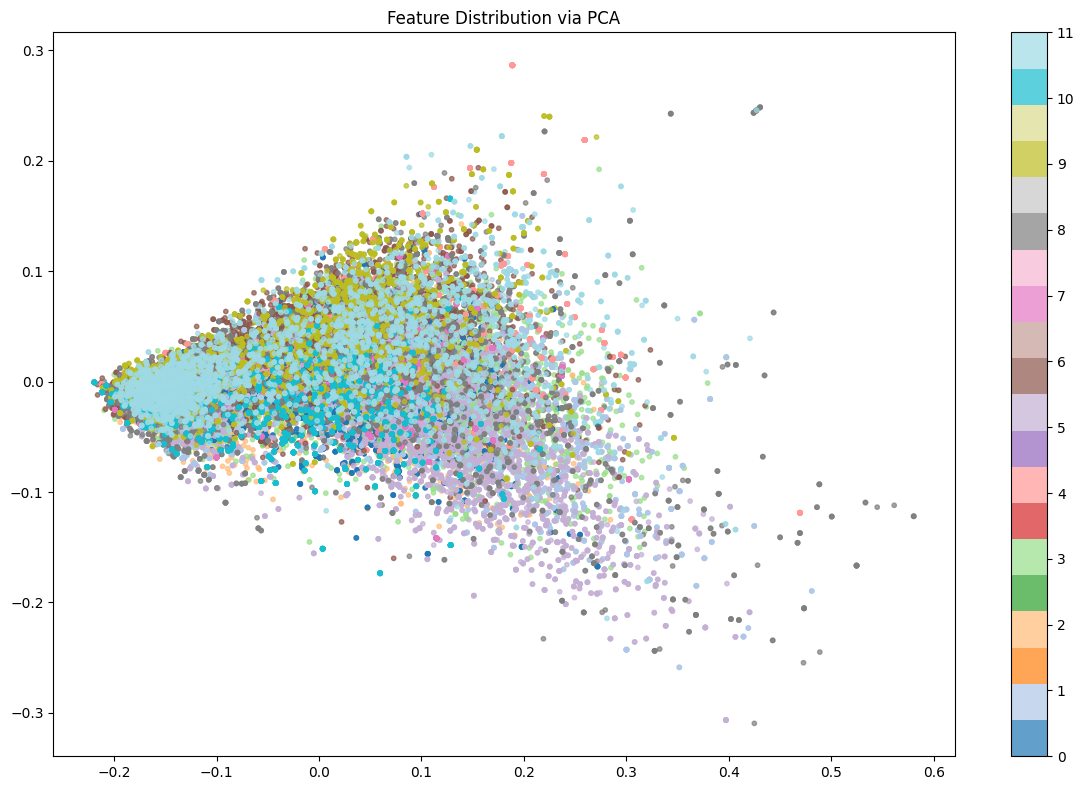

Processing Folds:  20%|██        | 1/5 [04:13<16:55, 253.79s/it]

✔ Fold 0 Faiss 인덱스 및 파라미터가 'image_classification_models\knn_faiss_voc_folds'에 저장되었습니다.

=== Fold 1 ===
[Fold 1] ▶ Train: 68793개, Test: 17199개
  ▶ Train feature extraction (Fold 1)...


  ✔ Train feature extraction complete for Fold 1. Feature Shape: (68793, 154)
  ✔ Faiss KNN 모델 학습 완료 (Fold 1).
  ▶ Test feature extraction (Fold 1)...














































































































































































































































































































































































































































































































  Extracting Test Features (Fold 1): 100%|██████████| 17199/17199 [01:01<00:00, 277.89it/s]


  ✔ Test feature extraction complete for Fold 1. Feature Shape: (17199, 154)
  ▶ KNN 예측 중 (Faiss 사용, k=5)...
  ✔ 예측 완료.
[Test Accuracy] 0.6726
               precision    recall  f1-score   support

      Bicycle       0.61      0.88      0.72      1433
       Bridge       0.70      0.93      0.79      1434
          Bus       0.35      0.29      0.32      1433
          Car       0.30      0.17      0.22      1433
      Chimney       0.94      1.00      0.97      1433
    Crosswalk       0.68      0.73      0.70      1433
      Hydrant       0.51      0.38      0.43      1434
   Motorcycle       0.93      1.00      0.96      1433
        Other       0.58      0.50      0.54      1433
         Palm       0.65      0.78      0.71      1433
        Stair       0.91      1.00      0.95      1433
Traffic Light       0.58      0.42      0.49      1434

     accuracy                           0.67     17199
    macro avg       0.64      0.67      0.65     17199
 weighted avg       0.64      

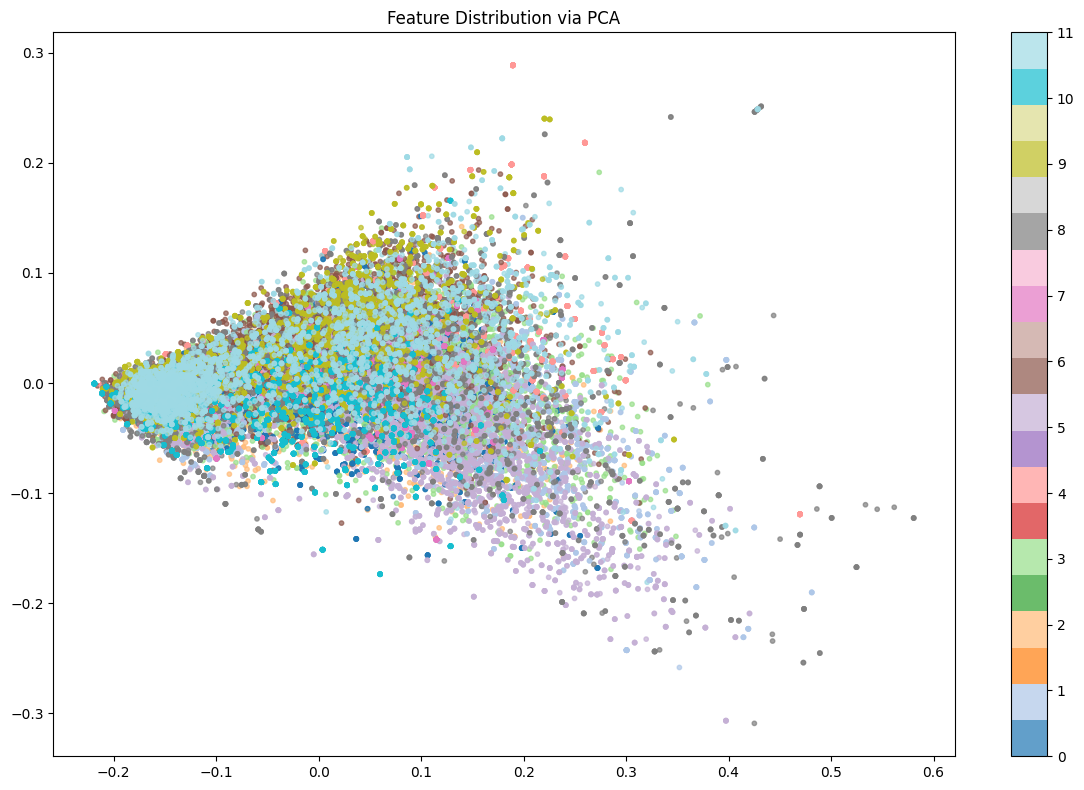

Processing Folds:  40%|████      | 2/5 [08:52<13:24, 268.27s/it]

✔ Fold 1 Faiss 인덱스 및 파라미터가 'image_classification_models\knn_faiss_voc_folds'에 저장되었습니다.

=== Fold 2 ===
[Fold 2] ▶ Train: 68794개, Test: 17198개
  ▶ Train feature extraction (Fold 2)...


  ✔ Train feature extraction complete for Fold 2. Feature Shape: (68794, 154)
  ✔ Faiss KNN 모델 학습 완료 (Fold 2).
  ▶ Test feature extraction (Fold 2)...

















































































































































































































































































































































































  Extracting Test Features (Fold 2): 100%|██████████| 17198/17198 [00:53<00:00, 321.10it/s]


  ✔ Test feature extraction complete for Fold 2. Feature Shape: (17198, 154)
  ▶ KNN 예측 중 (Faiss 사용, k=5)...
  ✔ 예측 완료.
[Test Accuracy] 0.6648
               precision    recall  f1-score   support

      Bicycle       0.62      0.86      0.72      1433
       Bridge       0.68      0.91      0.77      1433
          Bus       0.37      0.31      0.34      1434
          Car       0.29      0.18      0.22      1433
      Chimney       0.94      1.00      0.97      1433
    Crosswalk       0.68      0.72      0.70      1433
      Hydrant       0.50      0.37      0.43      1433
   Motorcycle       0.92      1.00      0.96      1434
        Other       0.57      0.45      0.50      1433
         Palm       0.62      0.76      0.69      1433
        Stair       0.91      0.99      0.95      1433
Traffic Light       0.55      0.42      0.48      1433

     accuracy                           0.66     17198
    macro avg       0.64      0.66      0.64     17198
 weighted avg       0.64      

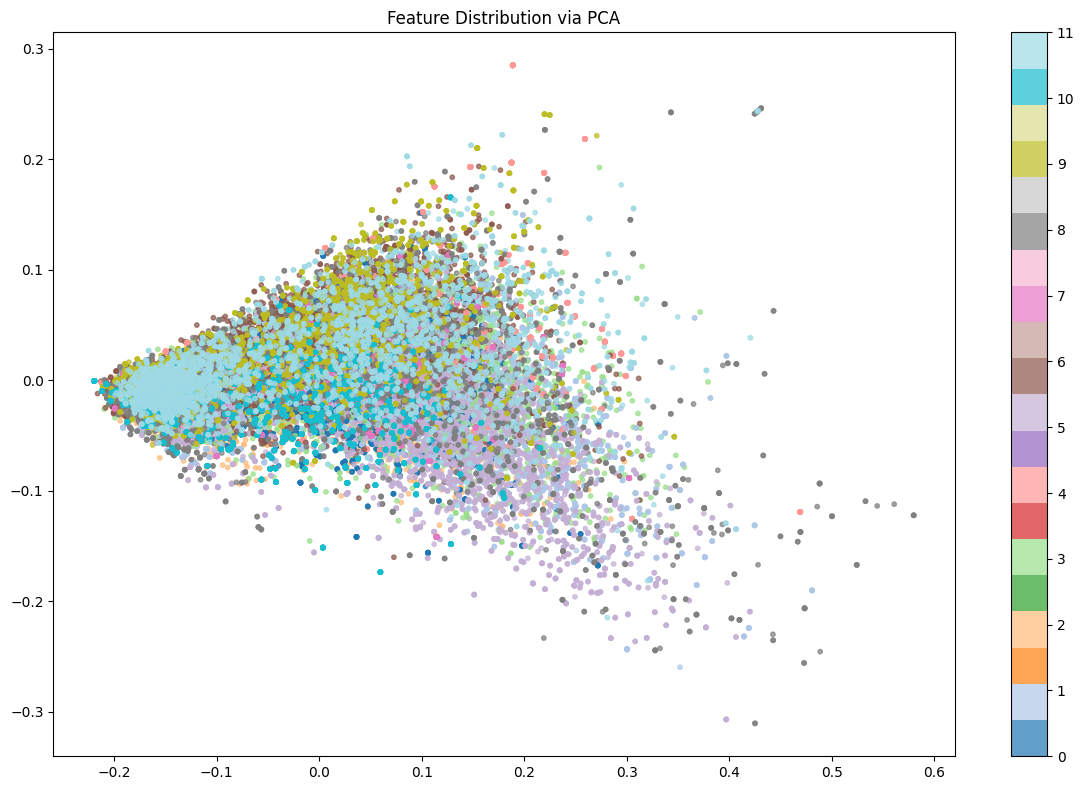

Processing Folds:  60%|██████    | 3/5 [13:36<09:11, 275.71s/it]

✔ Fold 2 Faiss 인덱스 및 파라미터가 'image_classification_models\knn_faiss_voc_folds'에 저장되었습니다.

=== Fold 3 ===
[Fold 3] ▶ Train: 68794개, Test: 17198개
  ▶ Train feature extraction (Fold 3)...


  ✔ Train feature extraction complete for Fold 3. Feature Shape: (68794, 154)
  ✔ Faiss KNN 모델 학습 완료 (Fold 3).
  ▶ Test feature extraction (Fold 3)...




















































































































































































































































































  Extracting Test Features (Fold 3): 100%|██████████| 17198/17198 [00:50<00:00, 341.53it/s]


  ✔ Test feature extraction complete for Fold 3. Feature Shape: (17198, 154)
  ▶ KNN 예측 중 (Faiss 사용, k=5)...
  ✔ 예측 완료.
[Test Accuracy] 0.6684
               precision    recall  f1-score   support

      Bicycle       0.62      0.84      0.71      1433
       Bridge       0.67      0.94      0.78      1433
          Bus       0.37      0.29      0.32      1433
          Car       0.29      0.18      0.22      1434
      Chimney       0.93      1.00      0.97      1433
    Crosswalk       0.70      0.72      0.71      1433
      Hydrant       0.51      0.36      0.42      1433
   Motorcycle       0.92      1.00      0.96      1433
        Other       0.58      0.48      0.52      1434
         Palm       0.64      0.78      0.70      1433
        Stair       0.92      1.00      0.96      1433
Traffic Light       0.54      0.44      0.48      1433

     accuracy                           0.67     17198
    macro avg       0.64      0.67      0.65     17198
 weighted avg       0.64      

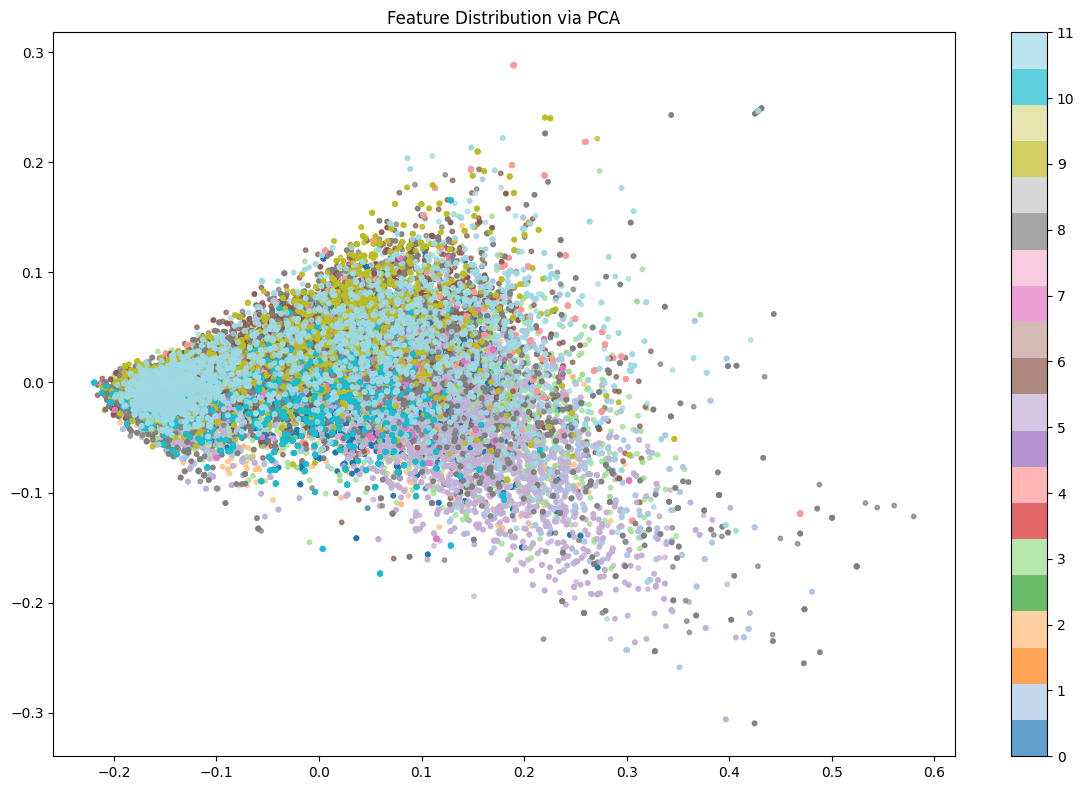

Processing Folds:  80%|████████  | 4/5 [17:55<04:28, 268.84s/it]

✔ Fold 3 Faiss 인덱스 및 파라미터가 'image_classification_models\knn_faiss_voc_folds'에 저장되었습니다.

=== Fold 4 ===
[Fold 4] ▶ Train: 68794개, Test: 17198개
  ▶ Train feature extraction (Fold 4)...


  ✔ Train feature extraction complete for Fold 4. Feature Shape: (68794, 154)
  ✔ Faiss KNN 모델 학습 완료 (Fold 4).
  ▶ Test feature extraction (Fold 4)...

























































































































































































































































































































































































































































































































































  Extracting Test Features (Fold 4): 100%|██████████| 17198/17198 [01:03<00:00, 271.08it/s]


  ✔ Test feature extraction complete for Fold 4. Feature Shape: (17198, 154)
  ▶ KNN 예측 중 (Faiss 사용, k=5)...
  ✔ 예측 완료.
[Test Accuracy] 0.6733
               precision    recall  f1-score   support

      Bicycle       0.61      0.84      0.71      1433
       Bridge       0.70      0.91      0.79      1433
          Bus       0.37      0.30      0.33      1433
          Car       0.32      0.20      0.24      1433
      Chimney       0.94      1.00      0.97      1434
    Crosswalk       0.70      0.73      0.72      1433
      Hydrant       0.49      0.37      0.42      1433
   Motorcycle       0.92      1.00      0.96      1433
        Other       0.58      0.50      0.54      1433
         Palm       0.64      0.78      0.70      1434
        Stair       0.91      1.00      0.95      1433
Traffic Light       0.58      0.44      0.50      1433

     accuracy                           0.67     17198
    macro avg       0.65      0.67      0.65     17198
 weighted avg       0.65      

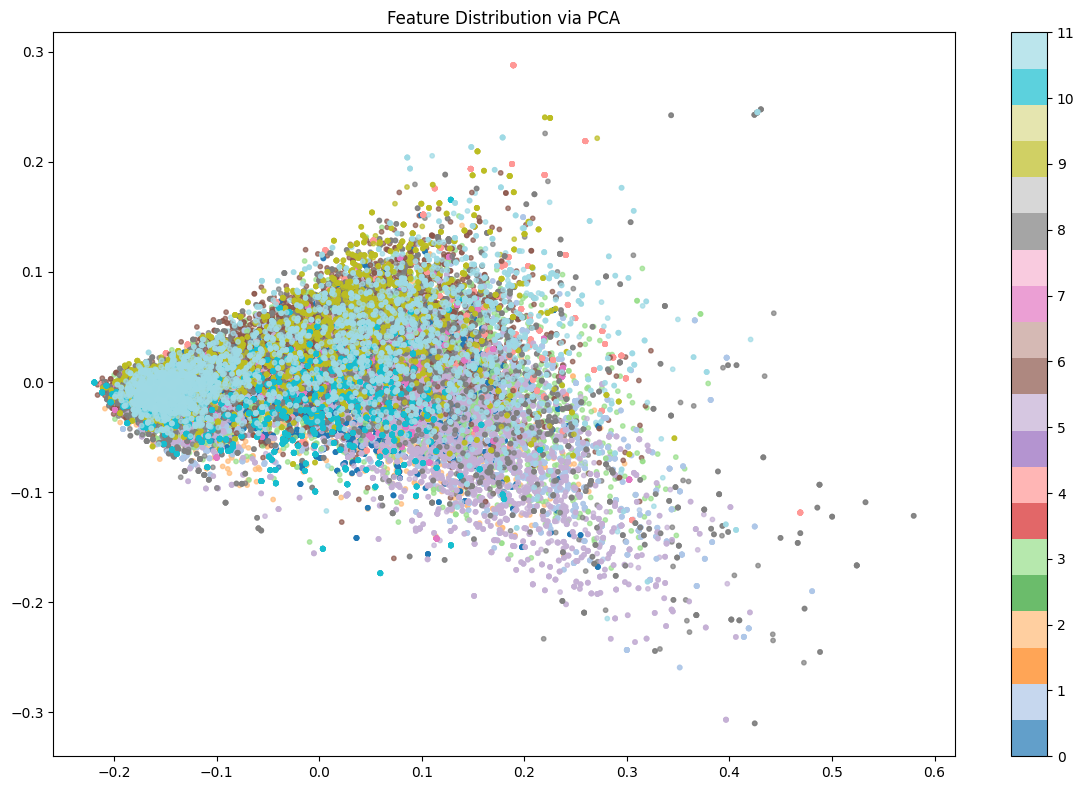

Processing Folds: 100%|██████████| 5/5 [22:29<00:00, 269.86s/it]

✔ Fold 4 Faiss 인덱스 및 파라미터가 'image_classification_models\knn_faiss_voc_folds'에 저장되었습니다.

=== 5-Fold CV Average ===
Accuracy : 0.6700 ± 0.0031
Precision: 0.6436 ± 0.0039
Recall   : 0.6700 ± 0.0031


In [25]:
# ==============================================================================
# 6. 5-Fold 교차 검증 루프 및 모델 저장
# ==============================================================================
accuracies = []
precisions = []
recalls = []

# 모델 저장 경로 설정 (사용자 로컬 PC 내)
# 현재 스크립트가 실행되는 폴더 내에 'image_classification_models' 폴더 생성
MODEL_SAVE_BASE_DIR = 'image_classification_models'
os.makedirs(MODEL_SAVE_BASE_DIR, exist_ok=True)
print(f"모델 저장 기본 경로: {os.path.abspath(MODEL_SAVE_BASE_DIR)}")


print("\n=== 5-Fold 교차 검증 시작 ===")
for i, (train_index, test_index) in tqdm(enumerate(skf.split(images_df_resampled, images_df_resampled['label_encoded'])), total=skf.get_n_splits(), desc="Processing Folds"):
    f = {
        'fold': i,
        'X_train': images_df_resampled.iloc[train_index]['image_data'].values,
        'y_train': images_df_resampled.iloc[train_index]['label_encoded'].values,
        'X_test': images_df_resampled.iloc[test_index]['image_data'].values,
        'y_test': images_df_resampled.iloc[test_index]['label_encoded'].values,
    }
    print(f"\n=== Fold {f['fold']} ===")
    print(f"[Fold {f['fold']}] ▶ Train: {len(f['X_train'])}개, Test: {len(f['X_test'])}개")

     # 1) train set에서 feature 추출 (병렬 처리 적용)
    print(f"  ▶ Train feature extraction (Fold {f['fold']})...")
    X_train_feats = Parallel(n_jobs=-1)( # n_jobs=-1로 모든 CPU 코어 사용
        delayed(lambda img: extract_features(preprocess_image(img)))(img)
        for img in tqdm(f['X_train'], desc=f"  Extracting Train Features (Fold {f['fold']})") 
    )
    X_train_feats = np.array(X_train_feats)
    print(f"  ✔ Train feature extraction complete for Fold {f['fold']}. Feature Shape: {X_train_feats.shape}")
    
    # Faiss KNN 모델 학습 (Index 생성)
    faiss_model_tuple = train_faiss_knn_cosine(
        X_train_feats,
        f['y_train'],
        n_neighbors=5
    )
    print(f"  ✔ Faiss KNN 모델 학습 완료 (Fold {f['fold']}).")

    # 2) test set에서 feature 추출 (병렬 처리 적용)
    print(f"  ▶ Test feature extraction (Fold {f['fold']})...")
    X_test_feats = Parallel(n_jobs=-1)( # n_jobs=-1로 모든 CPU 코어 사용
        delayed(lambda img: extract_features(preprocess_image(img)))(img)
        for img in tqdm(f['X_test'], desc=f"  Extracting Test Features (Fold {f['fold']})")
    )
    X_test_feats = np.array(X_test_feats)
    print(f"  ✔ Test feature extraction complete for Fold {f['fold']}. Feature Shape: {X_test_feats.shape}")
    
    # 평가
    y_pred = test(
        faiss_model_tuple,
        X_test_feats,
        f['y_test'],
        average='weighted'
    )

    visualize_features(X_train_feats, f['y_train'], method='pca') 


    # 폴드별 지표 저장
    acc = accuracy_score(f['y_test'], y_pred)
    prec = precision_score(f['y_test'], y_pred, average='weighted', zero_division=0)
    rec  = recall_score(f['y_test'], y_pred, average='weighted', zero_division=0)

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    
    # --- 각 폴드별 Faiss 모델 저장 ---
    fold_model_dir = os.path.join(MODEL_SAVE_BASE_DIR, 'knn_faiss_voc_folds')
    os.makedirs(fold_model_dir, exist_ok=True)
    fold_index_path = os.path.join(fold_model_dir, f'faiss_voc_index_fold_{f["fold"]}.bin')
    
    faiss.write_index(faiss_model_tuple[0], fold_index_path) # faiss_model_tuple[0]은 Faiss 인덱스
    joblib.dump(
        {'y_train_labels': faiss_model_tuple[1], 'n_neighbors': faiss_model_tuple[2]},
        os.path.join(fold_model_dir, f'faiss_voc_params_fold_{f["fold"]}.joblib')
    )
    print(f"✔ Fold {f['fold']} Faiss 인덱스 및 파라미터가 '{fold_model_dir}'에 저장되었습니다.")
    # --- 저장 부분 끝 ---


# 5) 5-fold 평균 지표 출력
print("\n=== 5-Fold CV Average ===")
print(f"Accuracy : {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall   : {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")

In [10]:
def test_on_new_dataset(fold_model_dir, X_test_feats, y_test, average='weighted'):
    """
    저장된 5개의 fold별 FAISS 모델을 불러와서 각각 예측하고, 앙상블 결과를 리턴
    - fold_model_dir: 폴드별 모델이 저장된 디렉토리
    - X_test_feats: 새로운 데이터셋의 feature vector (numpy array)
    - y_test: ground truth 라벨
    """
    all_preds = []

    for fold in range(5):
        # 모델 로드
        index_path = os.path.join(fold_model_dir, f'faiss_index_fold_{fold}.bin')
        param_path = os.path.join(fold_model_dir, f'faiss_params_fold_{fold}.joblib')

        faiss_index = faiss.read_index(index_path)
        params = joblib.load(param_path)
        y_train_labels = params['y_train_labels']
        k = params['n_neighbors']

        # 예측 수행
        print(f"\n▶ Fold {fold} 모델 예측 중...")
        y_pred = predict_faiss_knn_cosine(faiss_index, y_train_labels, k, X_test_feats)
        all_preds.append(y_pred)

    # 다수결 앙상블
    all_preds = np.array(all_preds)  # shape: (n_folds, n_samples)
    final_preds = []
    for i in range(all_preds.shape[1]):
        votes = all_preds[:, i]
        unique_labels, counts = np.unique(votes, return_counts=True)
        final_label = unique_labels[np.argmax(counts)]
        final_preds.append(final_label)
    final_preds = np.array(final_preds)

    # 평가
    print("\n=== 앙상블 평가 결과 ===")
    acc = accuracy_score(y_test, final_preds)
    prec = precision_score(y_test, final_preds, average=average, zero_division=0)
    rec = recall_score(y_test, final_preds, average=average, zero_division=0)
    print(f"[Ensemble Accuracy] {acc:.4f}")
    print(classification_report(y_test, final_preds))  # 클래스 이름 지정은 필요시 추가

    return final_preds, acc, prec, rec

In [12]:
# 1. 데이터 로드
fold_model_dir = 'image_classification_models/knn_faiss_folds'
DATASET_BASE_PATH = "C:/Users/bvb09/.cache/kagglehub/datasets/mikhailma/test-dataset/versions/1/Google_Recaptcha_V2_Images_Dataset"


print("▶ 이미지 데이터 로드 중...")
try:
    images_df = load_images_from_folder(DATASET_BASE_PATH)
    print(f"✔ 총 {len(images_df)}개의 이미지 로드 완료.")
except FileNotFoundError as e:
    print(f"오류: {e}")
    exit()

# 2. 상위 100개 라벨만 선택 (사전순 or 이미지 많은 순)
label_counts = images_df['label'].value_counts()
top_labels = label_counts.head(150).index  # 상위 100개 라벨

images_df = images_df[images_df['label'].isin(top_labels)]

# 3. 라벨별 100개씩 샘플링
images_df = images_df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), 100), random_state=42)
).reset_index(drop=True)
print(f"✔ 상위 100개 라벨에서 최대 100개씩 샘플링 완료. 총 이미지 수: {len(images_df)}")

# 4. 라벨 인코딩
le = LabelEncoder()
images_df['label_encoded'] = le.fit_transform(images_df['label'])
print(f"✔ 라벨 인코딩 완료. 클래스 수: {len(le.classes_)}")

# 5. Feature 추출
print("▶ Feature 추출 중...")
X_test_feats = [
    extract_features(preprocess_image(img))
    for img in tqdm(images_df['image_data'], desc="  Extracting Test Features")
]
X_test_feats = np.array(X_test_feats)
print(f"✔ Feature 추출 완료. Shape: {X_test_feats.shape}")

# 6. 라벨 추출
y_test = images_df['label_encoded'].values

# 7. 앙상블 평가
ensemble_model = EnsembleFaissKNN(fold_model_dir=fold_model_dir)
ensemble_model.load_models()
y_pred = ensemble_model.evaluate(X_test_feats, y_test, le=le)


▶ 이미지 데이터 로드 중...


Loading folders: 100%|██████████| 12/12 [00:07<00:00,  1.63it/s]
C:\Users\bvb09\AppData\Local\Temp\ipykernel_4892\1261212957.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  images_df = images_df.groupby('label', group_keys=False).apply(


✔ 총 11730개의 이미지 로드 완료.
✔ 상위 100개 라벨에서 최대 100개씩 샘플링 완료. 총 이미지 수: 1181
✔ 라벨 인코딩 완료. 클래스 수: 12
▶ Feature 추출 중...


  Extracting Test Features: 100%|██████████| 1181/1181 [00:09<00:00, 119.21it/s]


✔ Feature 추출 완료. Shape: (1181, 154)
✔ 5개의 Fold 모델 로딩 완료.

=== 앙상블 평가 결과 ===
Accuracy : 0.7697
Precision: 0.7545
Recall   : 0.7697
               precision    recall  f1-score   support

      Bicycle       0.76      0.84      0.80       100
       Bridge       0.75      0.97      0.84       100
          Bus       0.66      0.71      0.69       100
          Car       0.51      0.21      0.30       100
      Chimney       0.98      1.00      0.99       100
    Crosswalk       0.69      0.68      0.69       100
      Hydrant       0.72      0.77      0.74       100
   Motorcycle       0.93      1.00      0.96        81
        Other       0.66      0.50      0.57       100
         Palm       0.70      0.76      0.73       100
        Stair       0.95      1.00      0.98       100
Traffic Light       0.76      0.84      0.80       100

     accuracy                           0.77      1181
    macro avg       0.76      0.77      0.76      1181
 weighted avg       0.75      0.77      0.7

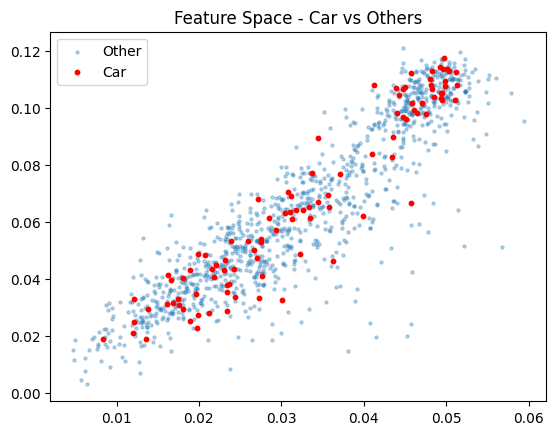

In [13]:
import matplotlib.pyplot as plt

car_indices = np.where(images_df['label'] == 'Car')[0]
other_indices = np.where(images_df['label'] != 'Car')[0]

plt.scatter(X_test_feats[other_indices][:, 0], X_test_feats[other_indices][:, 1], alpha=0.3, label='Other', s=5)
plt.scatter(X_test_feats[car_indices][:, 0], X_test_feats[car_indices][:, 1], alpha=1.0, label='Car', s=10, c='red')
plt.legend()
plt.title("Feature Space - Car vs Others")
plt.show()


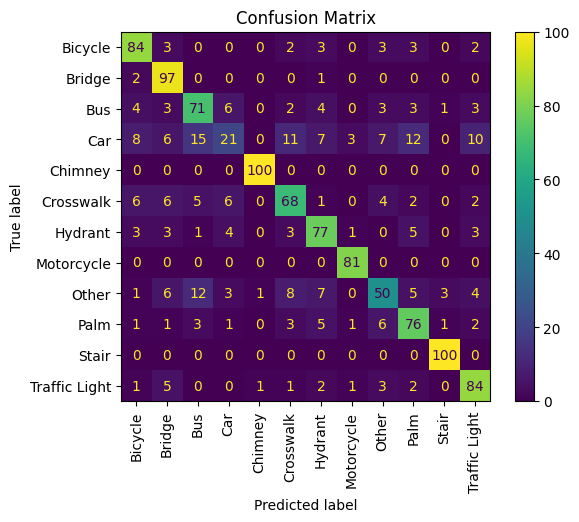

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

c:\Users\bvb09\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


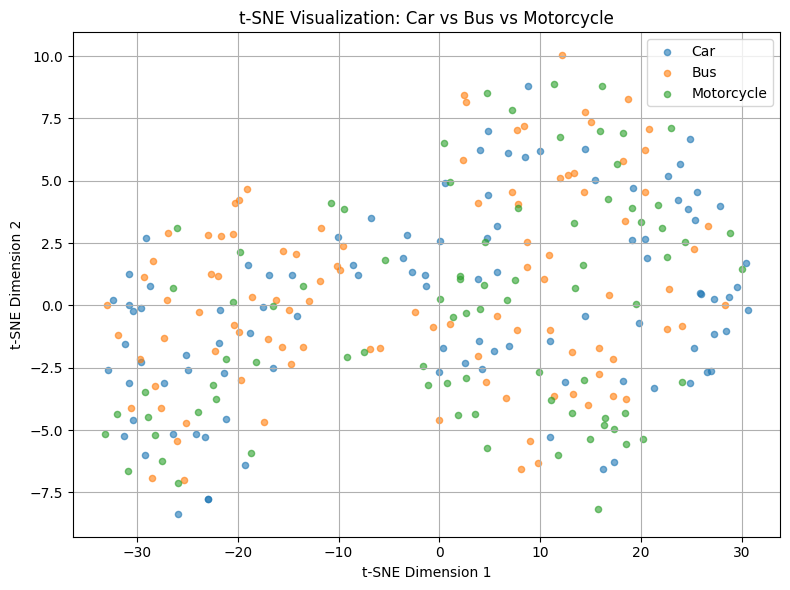

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 시각화 대상 클래스
target_classes = ['Car', 'Bus', 'Motorcycle']

# 대상 샘플 인덱스 추출
target_indices = images_df[images_df['label'].isin(target_classes)].index

# 대상 feature 및 라벨 추출
subset_feats = X_test_feats[target_indices]
subset_labels = images_df.loc[target_indices, 'label'].values

# t-SNE 변환
tsne = TSNE(n_components=2, perplexity=20, n_iter=500, random_state=42)
subset_feats_2d = tsne.fit_transform(subset_feats)

# 시각화
plt.figure(figsize=(8, 6))
for label in target_classes:
    idx = subset_labels == label
    plt.scatter(subset_feats_2d[idx, 0], subset_feats_2d[idx, 1], label=label, alpha=0.6, s=20)

plt.title("t-SNE Visualization: Car vs Bus vs Motorcycle")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
